In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
import math

In [3]:
def load_mnist_data():
    dataset1=pd.read_csv("../input/fashion-mnist_train.csv")
    y1=dataset1['label']
    y_train=np.array(y1).reshape(1,-1)
    xt1=[]
    for i in range(1,785):
        x1=dataset1['pixel'+str(i)]
        xt1.append(np.array(x1))
    x_t1=np.array(xt1) 
    dataset2=pd.read_csv("../input/fashion-mnist_test.csv")
    y2=dataset2['label']
    y_test=np.array(y2).reshape(1,-1)
    xt2=[]
    for i in range(1,785):
       x1=dataset2['pixel'+str(i)]
       xt2.append(np.array(x1))
    x_t2=np.array(xt2)
    return x_t1.T.reshape(-1,28,28),y_train,x_t2.T.reshape(-1,28,28),y_test


In [4]:
import os
os.listdir('../input')

['fashion-mnist_train.csv', 'fashion-mnist_test.csv']

In [5]:
def convert_to_one_hot(y,C):
    Y=np.eye(C)[y.reshape(-1)]
    return Y

In [6]:
def random_mini_batches(X,Y,minibatch_size):
    
    
    m=X.shape[0]
    mini_batches=[]
    
    permutation=list(np.random.permutation(m))
    
    shuffled_X=X[permutation,:,:]
    shuffled_Y=Y[permutation,:]
    
    
    number_of_minibatches=math.floor(m/minibatch_size)
    
    
    
    for k in range(number_of_minibatches):
        mini_batch_X=shuffled_X[k*minibatch_size:k*minibatch_size+minibatch_size,:,:]
        mini_batch_Y=shuffled_Y[k*minibatch_size:k*minibatch_size+minibatch_size,:]
        minibatch=(mini_batch_X,mini_batch_Y)
        mini_batches.append(minibatch)
        
    
    
    if m%minibatch_size != 0:
        mini_batch_X = shuffled_X[number_of_minibatches*minibatch_size:m,:,:]
        mini_batch_Y = shuffled_Y[number_of_minibatches*minibatch_size:m,:]
        minibatch=(mini_batch_X,mini_batch_Y)
    
    
    
    mini_batches.append(minibatch)
    return mini_batches

In [7]:
from tensorflow.python.framework import ops

In [8]:
train_X_orig,train_y_orig,test_X_orig,test_y_orig = load_mnist_data()
train_X=train_X_orig.reshape(-1,28,28,1)/255
test_X=test_X_orig.reshape(-1,28,28,1)/255
train_y=convert_to_one_hot(train_y_orig,10)
test_y=convert_to_one_hot(test_y_orig,10)

In [15]:
def network(X,krnls):
    inputs=tf.cast(tf.reshape(X,[-1,28,28,1]),tf.float32)    
    conv1=tf.nn.conv2d(inputs,krnls["1"],padding="SAME",strides=[1,1,1,1],name='conv1')
    pool1=tf.layers.max_pooling2d(inputs=conv1,pool_size=[2,2],strides=[2,2],name='pool1')
    b_norm1=tf.nn.relu(tf.layers.batch_normalization(inputs=pool1,momentum=0.99,center=True,scale=True,epsilon=0.000001,name="b_norm1"))
#    conv1=tf.layers.conv2d(inputs,filters=32,kernel_size=[3,3],strides=1,padding='same',activation='relu')
    
#    conv2=tf.layers.conv2d(inputs=pool1,filters=64,kernel_size=[3,3],strides=1,padding='same',activation='relu')
    conv2=tf.nn.conv2d(b_norm1,krnls["2"],padding="SAME",strides=[1,1,1,1],name='conv2')
    pool2=tf.layers.max_pooling2d(inputs=conv2,pool_size=[2,2],strides=[2,2],name='pool2')
    b_norm2=tf.nn.relu(tf.layers.batch_normalization(inputs=pool2,momentum=0.99,center=True,scale=True,epsilon=0.000001,name="b_norm2"))
    
#    conv3=tf.layers.conv2d(inputs=pool2,filters=128,kernel_size=[3,3],strides=1,padding='same',activation='relu')
    conv3=tf.nn.conv2d(b_norm2,krnls["3"],padding="SAME",strides=[1,1,1,1],name='conv3')
    pool3=tf.layers.max_pooling2d(inputs=conv3,pool_size=[2,2],strides=[2,2],name='pool3')
    b_norm3=tf.nn.relu(tf.layers.batch_normalization(inputs=pool3,momentum=0.99,center=True,scale=True,epsilon=0.000001,name="b_norm3"))
    
    
    flat=tf.reshape(pool3,[-1,pool3.shape[1]*pool3.shape[2]*pool3.shape[3]])
    dense1=tf.layers.dense(inputs=flat,units=512,activation=None,name="dense1")
    b_norm4=tf.nn.relu(tf.layers.batch_normalization(inputs=dense1,momentum=0.99,scale=True,center=True,epsilon=0.000001,name="b_norm4"))
    dropout1=tf.layers.dropout(inputs=b_norm4,rate=0.5,name="dropout1")
    dense2=tf.layers.dense(inputs=dropout1,units=256,activation=None,name="dense2")
    b_norm5=tf.nn.relu(tf.layers.batch_normalization(inputs=dense2,momentum=0.99,scale=True,center=True,epsilon=0.000001,name="b_norm5"))
    dropout2=tf.layers.dropout(inputs=b_norm5,rate=0.5,name="dropout2")
    logits=tf.layers.dense(inputs=dropout2,units=10,name="dense3")
    
    return logits

In [16]:
def create_placeholders(w,h,ny):
    x=tf.placeholder(tf.float32,[None,w,h,None],name='x')
    y=tf.placeholder(tf.int32,[None,10],name='y')
    return x,y


In [17]:
def initialize_kernels(channels):
    L=len(channels)

    parameter=dict()
    for i in range(1,L):
        parameter[str(i)]=tf.get_variable(name=str(i),shape=[3,3,channels[i-1],channels[i]],dtype=tf.float32,initializer=tf.contrib.layers.xavier_initializer())
        #parameter["b"+str(i)]=tf.get_variable(name="b"+str(i),shape=[channels[i]],dtype=tf.float32,initializer=tf.zeros_initializer())
        print(parameter[str(i)].shape)
        
    return parameter

In [18]:
def predict(X1,Y1):
    tf.reset_default_graph()
    (nx1,nx2,c)=X1.shape
    n_y=Y1.shape[0]
    X,Y=create_placeholders(nx1,nx2,n_y)
    costs=[]
    channels=np.array([1,16,32,64])
    krnls=initialize_kernels(channels)
    logits=network(X,krnls)
    saver=tf.train.Saver()
    sess=tf.Session()
    saver.restore(sess,"..input/mnist.ckpt")
    p=tf.argmax(logits,axis=1)
    prediction=sess.run(p,feed_dict={X:X1.reshape(-1,28,28,1),Y:Y1.reshape(-1,10)})
    plt.imshow(X1.reshape(28,28))
    print("Predicted class:",prediction," Original class:",np.argmax(Y1,axis=-1))
    return None

In [19]:
def model(train_X,train_y,test_X,test_y,learning_rate,epoch,batch_size):
    ops.reset_default_graph()
    (m,nx1,nx2,_)=train_X.shape
    n_y=train_y.shape[0]
    X,Y=create_placeholders(nx1,nx2,n_y)
    costs=[]
    channels=np.array([1,16,32,64])
    krnls=initialize_kernels(channels)
    logits=network(X,krnls)
    loss=tf.losses.softmax_cross_entropy(onehot_labels=Y,logits=logits)
    optimizer=tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    init=tf.global_variables_initializer()
    saver=tf.train.Saver()
    with tf.Session() as sess:
        sess.run(init)
       
        for epoch in range(epoch):
            epoch_cost=0
            minibatch_cost=0
            num_mini=int(m/batch_size)
            minibatch=random_mini_batches(train_X,train_y,100)
            for mini in minibatch:
                (mini_X,mini_y)=mini
                _,minibatch_cost=sess.run([optimizer,loss],feed_dict={X:mini_X,Y:mini_y})
                epoch_cost=epoch_cost+minibatch_cost/num_mini
#            if epoch%100==0:
            print("Cost after epoch %i: %f" %(epoch,epoch_cost))  
            if epoch%5==0:
                costs.append(epoch_cost)
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show() 
        correct_prediction = tf.equal(tf.argmax(logits,axis=1), tf.argmax(Y,axis=1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print ("Train Accuracy:", accuracy.eval({X: train_X, Y: train_y}))
        print ("Test Accuracy:", accuracy.eval({X: test_X, Y: test_y}))   
        saver.save(sess,"..input/mnist.ckpt")            
    return None

(3, 3, 1, 16)
(3, 3, 16, 32)
(3, 3, 32, 64)
Cost after epoch 0: 12.526098
Cost after epoch 1: 12.184338
Cost after epoch 2: 11.663555
Cost after epoch 3: 10.832148
Cost after epoch 4: 9.646704
Cost after epoch 5: 8.199902
Cost after epoch 6: 6.844727
Cost after epoch 7: 5.874282
Cost after epoch 8: 5.393362
Cost after epoch 9: 5.015622
Cost after epoch 10: 4.804063
Cost after epoch 11: 4.687207
Cost after epoch 12: 4.514578
Cost after epoch 13: 4.576196
Cost after epoch 14: 4.403019
Cost after epoch 15: 4.279096
Cost after epoch 16: 4.081602
Cost after epoch 17: 4.132589
Cost after epoch 18: 3.939197
Cost after epoch 19: 3.872988
Cost after epoch 20: 3.878765
Cost after epoch 21: 3.821872
Cost after epoch 22: 3.750824
Cost after epoch 23: 3.634014
Cost after epoch 24: 3.604513
Cost after epoch 25: 3.499451
Cost after epoch 26: 3.511227
Cost after epoch 27: 3.390928
Cost after epoch 28: 3.377362
Cost after epoch 29: 3.289319
Cost after epoch 30: 3.332503
Cost after epoch 31: 3.294708
Co

Cost after epoch 268: 0.312575
Cost after epoch 269: 0.262707
Cost after epoch 270: 0.354208
Cost after epoch 271: 0.332905
Cost after epoch 272: 0.290584
Cost after epoch 273: 0.301933
Cost after epoch 274: 0.210376
Cost after epoch 275: 0.229864
Cost after epoch 276: 0.231498
Cost after epoch 277: 0.235608
Cost after epoch 278: 0.213401
Cost after epoch 279: 0.222416
Cost after epoch 280: 0.222954
Cost after epoch 281: 0.199061
Cost after epoch 282: 0.209045
Cost after epoch 283: 0.222427
Cost after epoch 284: 0.248927
Cost after epoch 285: 0.218236
Cost after epoch 286: 0.229412
Cost after epoch 287: 0.208142
Cost after epoch 288: 0.212929
Cost after epoch 289: 0.244122
Cost after epoch 290: 0.229019
Cost after epoch 291: 0.222876
Cost after epoch 292: 0.160650
Cost after epoch 293: 0.180379
Cost after epoch 294: 0.173048
Cost after epoch 295: 0.214843
Cost after epoch 296: 0.224863
Cost after epoch 297: 0.214386
Cost after epoch 298: 0.251600
Cost after epoch 299: 0.198387
Cost aft

Cost after epoch 534: 0.008682
Cost after epoch 535: 0.008505
Cost after epoch 536: 0.007979
Cost after epoch 537: 0.007522
Cost after epoch 538: 0.010886
Cost after epoch 539: 0.010628
Cost after epoch 540: 0.008484
Cost after epoch 541: 0.007564
Cost after epoch 542: 0.006689
Cost after epoch 543: 0.007315
Cost after epoch 544: 0.007007
Cost after epoch 545: 0.006896
Cost after epoch 546: 0.007435
Cost after epoch 547: 0.008911
Cost after epoch 548: 0.007619
Cost after epoch 549: 0.006906
Cost after epoch 550: 0.007660
Cost after epoch 551: 0.006887
Cost after epoch 552: 0.007182
Cost after epoch 553: 0.006956
Cost after epoch 554: 0.006124
Cost after epoch 555: 0.005951
Cost after epoch 556: 0.006335
Cost after epoch 557: 0.006367
Cost after epoch 558: 0.005736
Cost after epoch 559: 0.005712
Cost after epoch 560: 0.006315
Cost after epoch 561: 0.005529
Cost after epoch 562: 0.005413
Cost after epoch 563: 0.005542
Cost after epoch 564: 0.005844
Cost after epoch 565: 0.006441
Cost aft

Cost after epoch 800: 0.000824
Cost after epoch 801: 0.000748
Cost after epoch 802: 0.000750
Cost after epoch 803: 0.000771
Cost after epoch 804: 0.000856
Cost after epoch 805: 0.000726
Cost after epoch 806: 0.000774
Cost after epoch 807: 0.000719
Cost after epoch 808: 0.000705
Cost after epoch 809: 0.000704
Cost after epoch 810: 0.000767
Cost after epoch 811: 0.000756
Cost after epoch 812: 0.000716
Cost after epoch 813: 0.000692
Cost after epoch 814: 0.000752
Cost after epoch 815: 0.000745
Cost after epoch 816: 0.000744
Cost after epoch 817: 0.000694
Cost after epoch 818: 0.000690
Cost after epoch 819: 0.000667
Cost after epoch 820: 0.000741
Cost after epoch 821: 0.000655
Cost after epoch 822: 0.000684
Cost after epoch 823: 0.000686
Cost after epoch 824: 0.000682
Cost after epoch 825: 0.000813
Cost after epoch 826: 0.000678
Cost after epoch 827: 0.000745
Cost after epoch 828: 0.000754
Cost after epoch 829: 0.000715
Cost after epoch 830: 0.000704
Cost after epoch 831: 0.000747
Cost aft

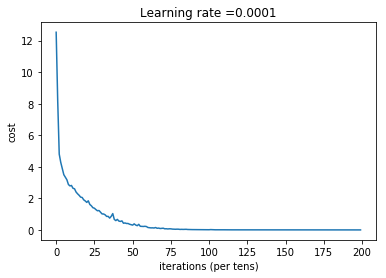

Train Accuracy: 1.0
Test Accuracy: 0.8201


In [20]:
model(train_X,train_y,test_X,test_y,0.0001,500,400)

(3, 3, 1, 16)
(3, 3, 16, 32)
(3, 3, 32, 64)
INFO:tensorflow:Restoring parameters from ..input/mnist.ckpt
Predicted class: [0]  Original class: 0


(60000, 10)

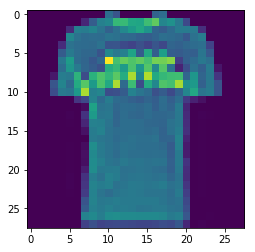

In [21]:
predict(test_X[9],test_y[9])
train_y.shape